<a href="https://colab.research.google.com/github/gyzzko/bias-in-data-science/blob/main/Mi_projet_contri_raphael.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Contexte métier et origine du dataset

Ce mi-projet s'inscrit dans le cadre de la recherche sur le diagnostic assisté par ordinateur d'images médicales de la poitrine.

Le descriptif Kaggle (disponible ici : https://www.kaggle.com/datasets/nih-chest-xrays/data, les éléments de cette introduction reprenant en partie le contenu de cette page) indique que les radiographies par rayons X de la poitrine sont l'un des actes les plus fréquents et les plus rentables de l'imagerie médicale, mais le diagnsotic peut être parfois plus fastifieux que sur un CT-Scan en 3D (plus cher à réaliser).


Pour simplifier le diagnoistic d es X-ray Scans, un algorithme de reconnaissance d'image pourrait aider les médecins et radiologistes dans leur travail. Pour entrainer ces algorhtmes, il faut des datasets de centaines de scans annotés. Sur ce projet, nous travaillons sur l'un de ces datasets, le NIH Chest X-ray Dataset.

En revanche, il ne faudrait pas entrainer des algos de ML avec des datasets biaisés, auquel cas les algos de diagnostic pourraient être discriminants. **Dans cette perspective, ce projet propose d'étudier puis mitiguer les biais inhérents au dataset**.


## Description du dataset :


Le NIH Chest X-ray Dataset contient 112,120 images rayons X dont le diagnostic à été annoté pour au total 30,805 patients différents.

Le dataset à l'étude est un sous échantillon aléatoire du dataset originel, comprenant 15,000 lignes (correspondant à 15,000 scans).

Voici les variables disponibles à l'étude :


```
    Image Index: File name
    Finding Labels: Disease type (Class label)
    Follow-up # (the id of the X-ray scan for a patient because one patient can have multiple scan in this dataset)
    Patient ID
    Patient Age
    Patient Gender
    View Position: X-ray orientation (AP stands for anteriorposterior and is an X-ray with patient facing machine, PA stands for posterioranterior and occurs when a patient's back is toward the machine)
    OriginalImageWidth
    OriginalImageHeight
    OriginalImagePixelSpacing_x
    OriginalImagePixelSpacing_y
  ```

Pour travailler sur l'identification des biais, nous considérerons dans ce projet que les trois variables ```Patient Age```, ```Patient Gender``` et ```View position``` sont des _sensitive variables_, i.e. des variables pour lesquelles le dataset ne doit pas être biaisé, car sinon les algorithmes qui utilisent ce dataset pourraient être discriminants, etc. La _target variable_ est le ```finding labels``` qui indique le diagnostic de l'annotation. [ Cf l'intro de cet article qui explique poiurquoi la variable View Position est importante à prendre en compte dans les analyses https://pmc.ncbi.nlm.nih.gov/articles/PMC12511169/ ]





## Objectifs du projet :
Ce mi-projet ne vise pas à travailler sur les biais d'un classificateur mais simplement a travailler les métadonnées des images pour en identifier les biais et effectuer de la mitigation pré-processing.

Identifier les biais présents dans un dataset est indispensable pour garantir que l'IA produise des diagnostics médicaux justes et équitables, évitant ainsi que certains patients soient moins bien diagnostiqués ou soignés à cause de biais liés à leur âge ou à leur sexe.

Dans ce notebook, il s'agira donc
- de préparer les données (identifier les éventuelles valeurs manquantes, les outliers etc.)
- faire de la dataviz pour avoir une première intuition des biais potentiels de ce jeu de données
- mesurer les biais avec des fairness metrics
- appliquer des méthodes de mitigation pré-processing et vérifier que les biais liés aux sensitive varaibles ont bien été réduits.






# 2. Chargement du dataset, import des librairies et présentation des colonnes



In [1]:
# To execute only in Colab
! python -m pip install numpy fairlearn plotly nbformat ipykernel aif360["inFairness"] aif360['AdversarialDebiasing'] causal-learn BlackBoxAuditing cvxpy dice-ml lime shapkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 804.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.8/191.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# chargemet du dataset
df = pd.read_csv('/content/Contri_Raphael.csv')

df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
4,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53924 entries, 0 to 53923
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  53924 non-null  object 
 1   Finding Labels               53924 non-null  object 
 2   Follow-up #                  53924 non-null  int64  
 3   Patient ID                   53924 non-null  int64  
 4   Patient Age                  53924 non-null  int64  
 5   Patient Gender               53924 non-null  object 
 6   View Position                53924 non-null  object 
 7   OriginalImage[Width          53924 non-null  int64  
 8   Height]                      53924 non-null  int64  
 9   OriginalImagePixelSpacing[x  53924 non-null  float64
 10  y]                           53924 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 4.5+ MB


## colonnes du dataset

Juste pour pouvoir les copier coller facilement

In [5]:
for e in df.columns :
  print(e)

Image Index
Finding Labels
Follow-up #
Patient ID
Patient Age
Patient Gender
View Position
OriginalImage[Width
Height]
OriginalImagePixelSpacing[x
y]


# 3. Nettoyage et préparation des données

## Sélection des colonnes

On ne garde pas les dimensions des scans

In [6]:
columns_to_drop = ['OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]']
df = df.drop(columns=columns_to_drop)


## Vérification des données manquantes

In [7]:
df.isnull().sum()

,0
Image Index,0
Finding Labels,0
Follow-up #,0
Patient ID,0
Patient Age,0
Patient Gender,0
View Position,0


Il n'y a pas de données manquantes dans ce dataset.

## Verification des valeurs aberrantes

**Pour la colonne Patient Age**

C'est une (la seule) colonne avec des données continues donc on peut tracer un boxplot qui indique si il y a des valeurs aberrantes.


Pour les boxplot de cette librairie, une valeur aberrante est une donnée située au-delà des "moustaches", càd à une distance de plus de 1.5 fois l'écart interquartile, au-dessus du 3ème quartile ou en dessous du 1er quartile.

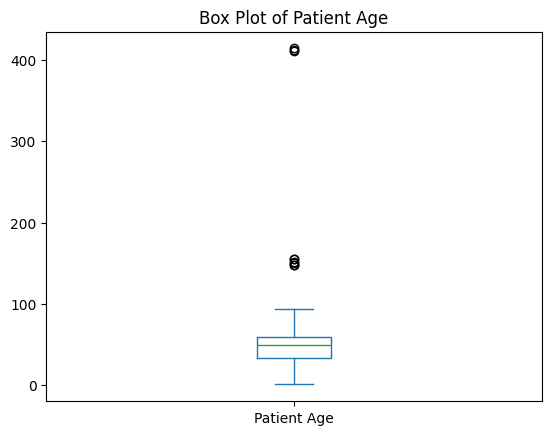

In [8]:
df["Patient Age"].plot(kind='box') # .plot() méthode de Pandas qui appelle matplotlib
plt.title(f'Box Plot of {"Patient Age"}')
plt.show()

On observe quelques valeurs aberrantes. Comme l'age dépend d'un scan d'un patient, mais qu'un patient peut avoir plusieurs scans (ie plusieurs lignes du dataset peuvent être associées au même patient), on peut regarder les autres ages enregistrés dans les autres scans d'un patient qui a un scan avec un age aberrant.

In [9]:
ages_above_100 = df[df['Patient Age'] > 100]['Patient Age'].value_counts().sort_index()

print(f"Nombre de lignes pour chaque âge supérieur à 100: {ages_above_100} ")

Nombre de lignes pour chaque âge supérieur à 100: Patient Age
148    2
150    1
152    1
155    2
411    1
412    1
414    1
Name: count, dtype: int64 


In [10]:
## description détaillée des infos poiur chaque patient qui a des outliers dans ses données.

print("\n--- Analyse des Patients avec des âges > 100 ---")

outlier_patient_ids = df[df['Patient Age'] > 100]['Patient ID'].unique() # on filtre les id des patients qui ont des outliers ie des ages > 100

print(f"Nombre de patients avec au moins un âge > 100: {len(outlier_patient_ids)}")
print(f"ID des patients concernés: {outlier_patient_ids}")

print("\n--- Détails pour chaque patient avec un âge > 100 ---")
for patient_id in outlier_patient_ids:
  patient_data = df[df['Patient ID'] == patient_id] ## on récupère les lignes des patients qui ont au mojns un outlier
  print(f"\nPatient ID: {patient_id}")
  print(f"Nombre de scans pour ce patient: {len(patient_data)}")
  print("Détails des scans pour ce patient:")
  display(patient_data[['Follow-up #', 'Patient Age', 'Patient Gender', 'Finding Labels']]) # display utilisé ici pour afficher plusieurs df dans la même execution de cellule notebook

  all_ages_outlier = (patient_data['Patient Age'] > 100).all() # vérifie si tous les ages du patient sont des outleirs, auquel cas on supprimera ce patient des données
  if all_ages_outlier:
    print(f"--> Tous les âges enregistrés pour le Patient {patient_id} sont supérieurs à 100.")
  else:
    print(f"--> Le Patient {patient_id} a des âges enregistrés inférieurs ou égaux à 100 et des âges supérieurs à 100. Il pourrait s'agir d'une erreur de saisie isolée ou d'une erreur dans le Patient ID lui-même si les âges sont très différents.")



--- Analyse des Patients avec des âges > 100 ---
Nombre de patients avec au moins un âge > 100: 9
ID des patients concernés: [11973 12238 13950 14520 18366 20900 22811 26871 27989]

--- Détails pour chaque patient avec un âge > 100 ---

Patient ID: 11973
Nombre de scans pour ce patient: 22
Détails des scans pour ce patient:


,Follow-up #,Patient Age,Patient Gender,Finding Labels
22409,0,65,M,No Finding
22410,1,65,M,Atelectasis
22411,2,414,M,Edema
22412,3,58,M,No Finding
22413,4,58,M,No Finding
22414,5,58,M,No Finding
22415,6,59,M,No Finding
22416,7,59,M,No Finding
22417,8,60,M,No Finding
22418,9,61,M,No Finding


--> Le Patient 11973 a des âges enregistrés inférieurs ou égaux à 100 et des âges supérieurs à 100. Il pourrait s'agir d'une erreur de saisie isolée ou d'une erreur dans le Patient ID lui-même si les âges sont très différents.

Patient ID: 12238
Nombre de scans pour ce patient: 15
Détails des scans pour ce patient:


,Follow-up #,Patient Age,Patient Gender,Finding Labels
23033,0,63,M,No Finding
23034,1,63,M,No Finding
23035,2,63,M,Atelectasis|Fibrosis
23036,3,63,M,No Finding
23037,4,63,M,Atelectasis
23038,5,63,M,No Finding
23039,6,64,M,Atelectasis|Effusion
23040,7,63,M,No Finding
23041,8,63,M,Effusion
23042,9,64,M,Effusion


--> Le Patient 12238 a des âges enregistrés inférieurs ou égaux à 100 et des âges supérieurs à 100. Il pourrait s'agir d'une erreur de saisie isolée ou d'une erreur dans le Patient ID lui-même si les âges sont très différents.

Patient ID: 13950
Nombre de scans pour ce patient: 8
Détails des scans pour ce patient:


,Follow-up #,Patient Age,Patient Gender,Finding Labels
26823,0,148,M,No Finding
26824,1,64,M,No Finding
26825,2,64,M,No Finding
26826,3,64,M,No Finding
26827,4,64,M,Atelectasis
26828,5,65,M,No Finding
26829,6,65,M,No Finding
26830,7,65,M,Atelectasis|Infiltration


--> Le Patient 13950 a des âges enregistrés inférieurs ou égaux à 100 et des âges supérieurs à 100. Il pourrait s'agir d'une erreur de saisie isolée ou d'une erreur dans le Patient ID lui-même si les âges sont très différents.

Patient ID: 14520
Nombre de scans pour ce patient: 27
Détails des scans pour ce patient:


,Follow-up #,Patient Age,Patient Gender,Finding Labels
28275,0,32,M,No Finding
28276,1,32,M,No Finding
28277,2,32,M,No Finding
28278,3,32,M,No Finding
28279,4,32,M,No Finding
28280,5,32,M,Pneumothorax
28281,6,32,M,No Finding
28282,7,32,M,No Finding
28283,8,32,M,Infiltration|Pneumonia
28284,9,32,M,No Finding


--> Le Patient 14520 a des âges enregistrés inférieurs ou égaux à 100 et des âges supérieurs à 100. Il pourrait s'agir d'une erreur de saisie isolée ou d'une erreur dans le Patient ID lui-même si les âges sont très différents.

Patient ID: 18366
Nombre de scans pour ce patient: 68
Détails des scans pour ce patient:


,Follow-up #,Patient Age,Patient Gender,Finding Labels
36023,0,64,F,Nodule
36024,1,65,F,Nodule|Pneumothorax
36025,2,64,F,Pneumothorax
36026,3,64,F,No Finding
36027,4,64,F,Infiltration
...,...,...,...,...
36086,63,66,F,No Finding
36087,64,66,F,No Finding
36088,65,66,F,No Finding
36089,66,66,F,No Finding


--> Le Patient 18366 a des âges enregistrés inférieurs ou égaux à 100 et des âges supérieurs à 100. Il pourrait s'agir d'une erreur de saisie isolée ou d'une erreur dans le Patient ID lui-même si les âges sont très différents.

Patient ID: 20900
Nombre de scans pour ce patient: 19
Détails des scans pour ce patient:


,Follow-up #,Patient Age,Patient Gender,Finding Labels
40722,0,72,M,Atelectasis
40723,1,72,M,No Finding
40724,2,411,M,No Finding
40725,3,70,M,Infiltration
40726,4,70,M,Infiltration
40727,5,71,M,Infiltration
40728,6,71,M,Infiltration
40729,7,71,M,Infiltration
40730,8,71,M,No Finding
40731,9,71,M,No Finding


--> Le Patient 20900 a des âges enregistrés inférieurs ou égaux à 100 et des âges supérieurs à 100. Il pourrait s'agir d'une erreur de saisie isolée ou d'une erreur dans le Patient ID lui-même si les âges sont très différents.

Patient ID: 22811
Nombre de scans pour ce patient: 6
Détails des scans pour ce patient:


,Follow-up #,Patient Age,Patient Gender,Finding Labels
43705,0,412,M,No Finding
43706,1,25,M,No Finding
43707,2,25,M,No Finding
43708,3,25,M,No Finding
43709,4,25,M,No Finding
43710,5,25,M,No Finding


--> Le Patient 22811 a des âges enregistrés inférieurs ou égaux à 100 et des âges supérieurs à 100. Il pourrait s'agir d'une erreur de saisie isolée ou d'une erreur dans le Patient ID lui-même si les âges sont très différents.

Patient ID: 26871
Nombre de scans pour ce patient: 1
Détails des scans pour ce patient:


,Follow-up #,Patient Age,Patient Gender,Finding Labels
48401,0,155,F,No Finding


--> Tous les âges enregistrés pour le Patient 26871 sont supérieurs à 100.

Patient ID: 27989
Nombre de scans pour ce patient: 1
Détails des scans pour ce patient:


,Follow-up #,Patient Age,Patient Gender,Finding Labels
50195,0,155,M,No Finding


--> Tous les âges enregistrés pour le Patient 27989 sont supérieurs à 100.


On voit que
- deux personnes ont leurs scans dont les ages sont tous des outliers
- poiur les autre personnes, leurs autres scans n'ont pas d'outliers. On peut donc faire une moyenne pour remplacer l'age outlier par la moyenne des autres ages des scans de la même personne.

In [11]:
patients_to_delete = []
for pid in outlier_patient_ids:
    patient_scans = df[df['Patient ID'] == pid]
    # Si tous les scans du patient dépassent le seuil
    if (patient_scans['Patient Age'] > 100).all():
        patients_to_delete.append(pid)


df_cleaned = df[~df['Patient ID'].isin(patients_to_delete)].copy() # .isin vérifie, pour chaque ligne, si l'ID du patient est présent dans la liste patients_to_delete
print(f"Patients supprimés (scans 100% aberrants) : {patients_to_delete}")



remaining_outlier_pids = [pid for pid in outlier_patient_ids if pid not in patients_to_delete]

for pid in remaining_outlier_pids:
    patient_mask = df_cleaned['Patient ID'] == pid

    # Calcul de l'âge moyen pour les valeurs aberrantes restantes à traiter
    normal_ages = df_cleaned.loc[patient_mask & (df_cleaned['Patient Age'] <= 100), 'Patient Age']
    mean_age = int(round(normal_ages.mean()))

    # Identification des indices des lignes aberrantes pour ce patient
    outlier_indices = df_cleaned.index[patient_mask & (df_cleaned['Patient Age'] > 100)]

    # Remplacement des valeurs
    df_cleaned.loc[outlier_indices, 'Patient Age'] = mean_age
    print(f"Patient {pid} : outlier remplacé par l'âge moyen ({mean_age} ans)")

Patients supprimés (scans 100% aberrants) : [np.int64(26871), np.int64(27989)]
Patient 11973 : outlier remplacé par l'âge moyen (61 ans)
Patient 12238 : outlier remplacé par l'âge moyen (63 ans)
Patient 13950 : outlier remplacé par l'âge moyen (64 ans)
Patient 14520 : outlier remplacé par l'âge moyen (32 ans)
Patient 18366 : outlier remplacé par l'âge moyen (64 ans)
Patient 20900 : outlier remplacé par l'âge moyen (71 ans)
Patient 22811 : outlier remplacé par l'âge moyen (25 ans)


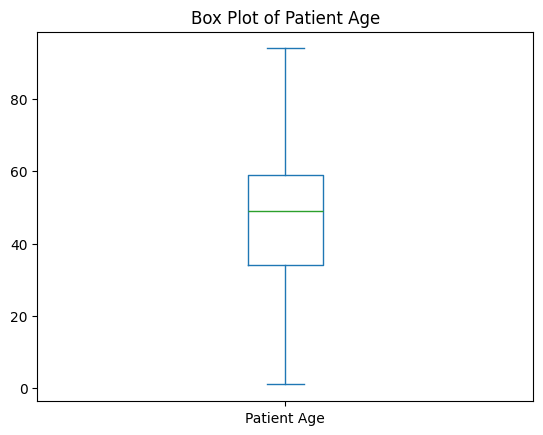

In [12]:
df_cleaned["Patient Age"].plot(kind='box')
plt.title(f'Box Plot of {"Patient Age"}')
plt.show()

La méthode de traitement des outliers a donc bien fonctionné

In [13]:
df = df_cleaned.copy()

## Transformations du type des colonnes

J'ai fait le choix de transformer le type de certaines colonnes (catégoriser des variables continues (pour l'age), ou diminuer le nombre de catégories de certaines variables avec énormément de catégories (pour Finding Labels). Je fais ces transformations pour faciliter les anlyses, **mais je les effectue plus tard pour qu'il y ait un déroulé logique dans le raisonnement du notebook**.

# Analyse descriptive

## Analyse univariée



Nous allons visualiser la **distribution des âges et du genre des patients** pour comprendre la composition démographique du jeu de données, ainsi que la **view position** qui sera importante pour le reste de l'étude. Ces trois variables sont de potentielles *sensitive variables*. Pour la View Position, il n'est pas évident de penser qu'il s'agit d'une sensitive variable. Mais on peut émettre l'hypothèse que les raisons qui mènent a se faire scanner dans la position PA plutot que AP relèvent de sensitives variables cachées (non présentes dans le dataset). Il est donc important de quand même considérer la View Position dans ce dataset. **En effet, en lisant le résumé de cet article, https://pmc.ncbi.nlm.nih.gov/articles/PMC12511169/ on comprend que la View Position n'est pas une variable anodine**.

### Barplot de l'âge


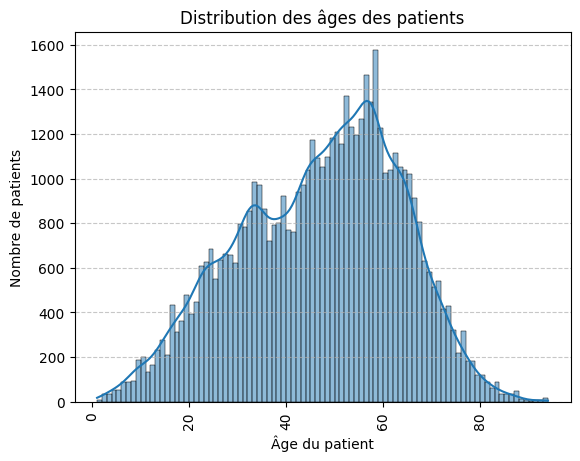

In [14]:
sns.histplot(x='Patient Age', data=df, binwidth=1, legend=False, kde = True)
plt.title('Distribution des âges des patients')
plt.xlabel('Âge du patient')
plt.ylabel('Nombre de patients')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

D'après ce graphique, la répartition des ages semble suivre une sorte de loi normale. L'age n'est donc pas réparti de manière égale dans ce dataset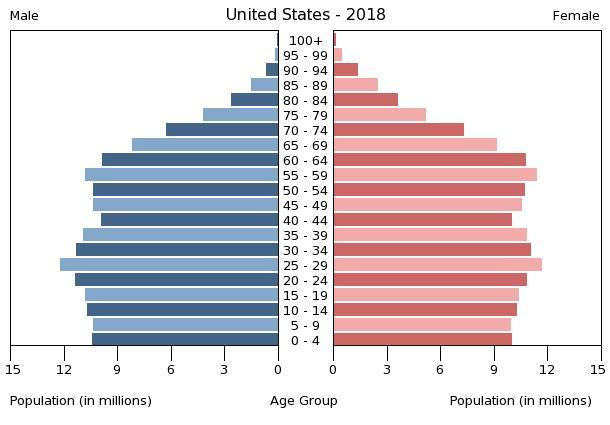



On voit avec cete pyramide des ages des états unis (prise sur wikipedia) que l'age du dataset n'est pas distribuée comme l'age de la population américaine, ce qui peut potentiellmeent mener a un biais de rerésentativité. Mais ce qui compte réellement, c'est de savoir si la distribution de l'age de ce dataset suit la distribution de l'age de la population malade, à mon avis (donnée un peu plus complexe à avoir). On ne peut donc pas vraiment conclure sur des biais de représentativité potentiels sur l'age en regardant ce graphique.

Dans la suite des analyses, on va catégoriser l'age(pour les analyses bivariées et le travail sur les biais)


**Utiliser des déciles est important**. En effet, cela permet de comparer des groupes de tailles similaires, ce qui rend les conclusions sur les taux de maladie plus robustes et moins sensibles aux fluctuations dues à de très petits échantillons dans certaines catégories

In [15]:
df['Age_Decile'] = pd.qcut(df['Patient Age'], q=10, labels=False, duplicates='drop') # pd.qcut divise les données de manière à ce que chaque intervalle contienne environ le même nombre d'observations, contrairement a pd.cut

print("Value counts for new 'Age_Decile' column:")
print(df['Age_Decile'].value_counts().sort_index())

# Calculate and print the age range for each decile
age_decile_ranges = df.groupby('Age_Decile')['Patient Age'].agg(['min', 'max'])
print("\nAge range for each decile:")
print(age_decile_ranges)

Value counts for new 'Age_Decile' column:
Age_Decile
0    5513
1    5389
2    5989
3    5402
4    5597
5    4959
6    5268
7    5982
8    4827
9    4996
Name: count, dtype: int64

Age range for each decile:
            min  max
Age_Decile          
0             1   23
1            24   31
2            32   38
3            39   44
4            45   49
5            50   53
6            54   57
7            58   62
8            63   67
9            68   94


On remarque que comme les ages ne ont pas répartis également dans le dataset, les déciles d'age 0 et 9 couvrent une grande plage d'age contraitrement aux déciles du milieu.


**Rq** : c'est normal si dans chaque décile il n'y a pas le même nombre d'individus, cf cette conv stackoverfow https://stackoverflow.com/questions/35183921/pandas-qcut-not-putting-equal-number-of-observations-into-each-bin

### Pie chart du genre

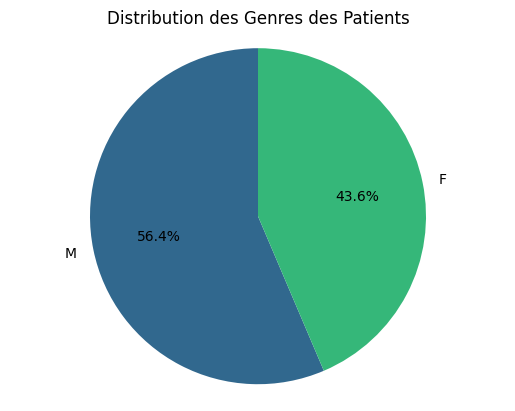

In [16]:
gender_counts = df['Patient Gender'].value_counts()

## seaborn n'a pas d efonciton pie chart, on utilise donc matplotlib, voir https://www.geeksforgeeks.org/python/how-to-create-a-pie-chart-in-seaborn/
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(gender_counts)))
plt.title('Distribution des Genres des Patients')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Sur ce graphique, on peut émettre l'hypothèse d'un potentiel biais de représentativité puiqu'il y a un peu plus d'hommes que de femmes (13 pts de pourcentage de différence). encore une fois, il faudrait connaitre la distribution homme-femme réelle des patients qui ont des scanners pour conclure sur un potentiel biais de représentativité.




**cf le duumbell plot dans les analyses multivariées pour une analyse plus fien en terme d'age et de genre**

### Etude descriptive de la variable Finding Labels

In [17]:
df["Finding Labels"].nunique()

612

In [18]:
(df["Finding Labels"].value_counts(normalize=True) * 100).head(60)

,proportion
Finding Labels,
No Finding,53.959423
Infiltration,8.536404
Atelectasis,3.916769
Effusion,3.356700
Nodule,2.384926
Mass,2.041838
Pneumothorax,1.882349
Effusion|Infiltration,1.385334
Atelectasis|Infiltration,1.212863


Il y a 612 valeurs diffrentes dans la colonne diagnostique, mais en fait la plupart des données sont en No Finding, indiquant que le diagnoostique a conclu que le patient n'avait rien. Les 612 valeurs différentes sont dues a des combinaisons de plusieurs diagnostiques. On pourrait par exemple ne garder que les diagnostiques uniques, ou ne garder que 15 premiers diagnostiques les plus courants, mais le plus simple est de binariser la colonne de la manière suivante :
1 : diagnistique
0 : pas diagnostique

C'est ce qu'on utilisera dans la suite de l'analyse.

In [19]:
df['findings_bins'] = df['Finding Labels'].apply(lambda x: 0 if x == 'No Finding' else 1)

In [20]:
df.findings_bins.value_counts(normalize=True)

,proportion
findings_bins,
0,0.539594
1,0.460406


il y a bien 53.961130 %  de no labels

### Etude de la variable View position

Cette varaible peut être intéressante dans les analyses car elle peut indiquer certains biais potentiels comme écrit plius haut, en lisant le résumé de cet article, https://pmc.ncbi.nlm.nih.gov/articles/PMC12511169/ on comprend que la View Position n'est pas une variable anodine.)

- PA (Postéro-Antérieure) : Le patient est debout, la poitrine contre la plaque. C'est la vue standard "idéale" car le cœur est proche de la plaque, ce qui évite de déformer sa taille.

- AP (Antéro-Postérieure) : Les rayons passent de l'avant vers l'arrière. Cette vue est souvent prise avec un appareil mobile au chevet du patient.

Le choix de la position n'est pas aléatoire, ce qui crée un biais statistique :

- Les patients en vue PA sont généralement assez valides pour se tenir debout (souvent des examens de routine ou des patients moins graves).

- Les patients en vue AP sont souvent trop faibles ou malades pour se lever (patients hospitalisés, alités ou en soins intensifs).

- Le risque pour l'IA : Si 80 % des patients en vue "AP" sont malades, l'algorithme peut apprendre un raccourci : "Si je vois une image en vue AP, je prédis qu'il est malade", sans même regarder les poumons. C'est ce qu'on appelle un biais de corrélation fallacieuse.

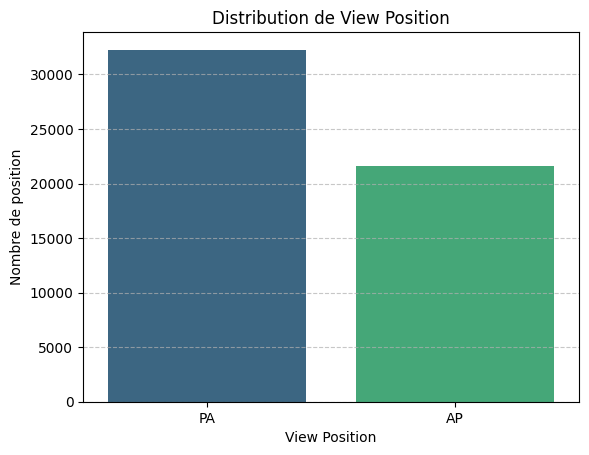

In [21]:
sns.countplot(x='View Position', data=df, palette='viridis', hue='View Position') # Removed legend=False
plt.title('Distribution de View Position')
plt.xlabel('View Position')
plt.ylabel('Nombre de position')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

On observe visuellement qu'il y a davantage de scans dans la position PA que dans la position AP, ce qui, encore une fois, peut mener a un potentiel biais de représentativité si cette distribution n'estpas reprsentative de la distribution réelle de la position des personnes scannées (ce qu'on ne peut pas réellement savoir ici).

## Analyse multivariée


Pour découvrir des biais qui sont conditionnels à plusieurs attributs sensibles ou contextuels, et qui ne seraient pas apparents en n'étudiant qu'une seule variable à la fois.



Dans cette partie on discute un peu de potentiels biais d'échantillonage (**rappel biais d'échantillonage** :  Similar to the representation bias, occurs when non-random
sampling of subgroups is performed. Due to sampling bias, trends estimated for
one population may not generalize to data collected from a new population.), à ne pas confondre avec biais de représentativité.

### Distribution de l'age en fonction du genre

On utilise un Dumbell Plot pour visualiser les données de manière plus facile qu'avec un simple barchart H/F.

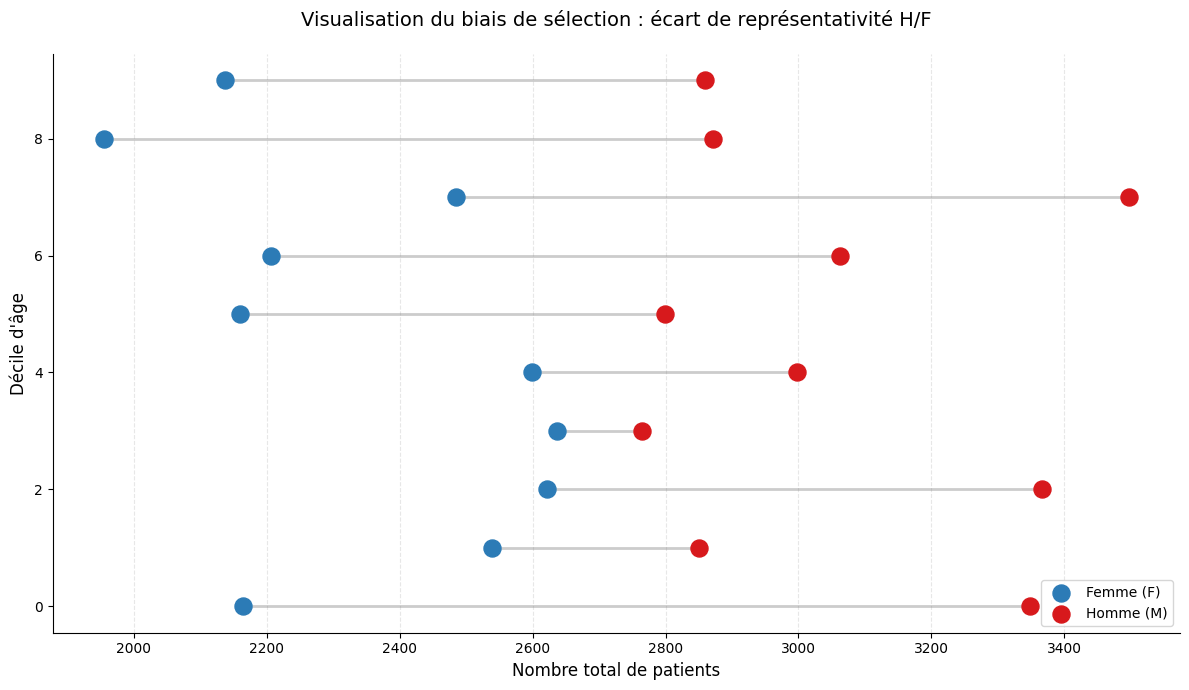

In [22]:
# --- Préparation des données pour le Dumbbell Plot ---
# On calcule le compte par genre et par décile
counts = df.groupby(['Age_Decile', 'Patient Gender']).size().unstack().reset_index()

plt.figure(figsize=(12, 7))

# 1. Tracer la ligne (le "gap")
plt.hlines(y=counts['Age_Decile'], xmin=counts['F'], xmax=counts['M'],
           color='grey', alpha=0.4, linewidth=2)

# 2. Tracer les points
plt.scatter(counts['F'], counts['Age_Decile'], color='#2c7bb6', label='Femme (F)', s=150, zorder=3)
plt.scatter(counts['M'], counts['Age_Decile'], color='#d7191c', label='Homme (M)', s=150, zorder=3)

# Cosmétique
plt.title('Visualisation du biais de sélection : écart de représentativité H/F', fontsize=14, pad=20)
plt.xlabel('Nombre total de patients', fontsize=12)
plt.ylabel('Décile d\'âge', fontsize=12)
plt.legend(frameon=True, loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


Le graphique met en évidence un déséquilibre marqué entre les genres sur l'ensemble de l'échantillon. Pour chaque décile d'âge (de 0 à 9), le nombre d'hommes (points rouges) est systématiquement supérieur au nombre de femmes (points bleus). Si le déséquilibre n'était dû qu'au hasard, on pourrait peut être s'attendre à ce que les femmes soient majoritaires dans au moins quelques catégories. Le fait que le point rouge (H) soit systématiquement à droite du point bleu (F) indique un biais d'échantillonnage systématique.



Par ailleurs, l'écart de représentativité (la longueur de la ligne grise entre les deux points) n'est pas uniforme. Aux extrémités (déciles 0, 8, 9), on observe les écarts les plus importants. Cela signifie que la sous-représentation des femmes estplus importante chez les patients les plus jeunes et les plus âgés. Au contraire, au centre (déciles 3, 4, 5), les points sont plus rapprochés, indiquant une répartition un peu plus équilibrée (bien que toujours favorable aux hommes) dans les tranches d'âge intermédiaires.


**Conclusion** : Cette visualisation permet d'émettre l'hypothèse un biais d'échantillonnage et de représentativité potentiel. Si que le pie chart indiquait une proportion globale de 56,4 % d'hommes, le dumbbell plot démontre que ce biais persiste et s'accentue dans certaines catégories d'âge spécifiques. Si la population réelle est paritaire, on pourrait conclure a un biais d'échantillonage.



### Taux de maladies par genre

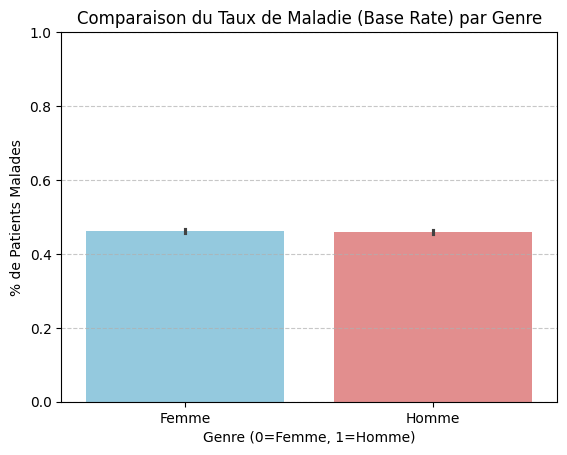

In [23]:
# Ensure 'sex' column is present by creating it from 'Patient Gender'
df['sex'] = df['Patient Gender'].map({'F': 0, 'M': 1})

sns.barplot(x='sex', y='findings_bins', data=df, hue='sex', palette={0: 'skyblue', 1: 'lightcoral'}, legend=False) # Fixed palette keys and addressed FutureWarning
plt.title('Comparaison du Taux de Maladie (Base Rate) par Genre')
plt.xlabel('Genre (0=Femme, 1=Homme)')
plt.ylabel('% de Patients Malades')
plt.xticks(ticks=[0, 1], labels=['Femme', 'Homme'])
plt.ylim(0, 1) # Ensure y-axis is from 0 to 1 for percentage
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

L'égalité des taux de diagnostic  entre hommes et femmes est suspecte au vu du déséquilibre démographique du dataset (majorité d'hommes). Cela suggère un **biais d'échantillonnage** : les femmes présentes dans l'étude semblent présenter un profil de risque plus élevé que les hommes. Il serait pertinent de segmenter cette analyse par tranche d'âge pour vérifier si un **Paradoxe de Simpson** ne masque pas une prévalence masculine plus forte dans chaque catégorie d'âge, annulée ici par un effet de structure de la population. C'est ce que l'on fait dans la partie ```3 variables : Distribution des maladies par age et genre```

### Taux de  maladies par age

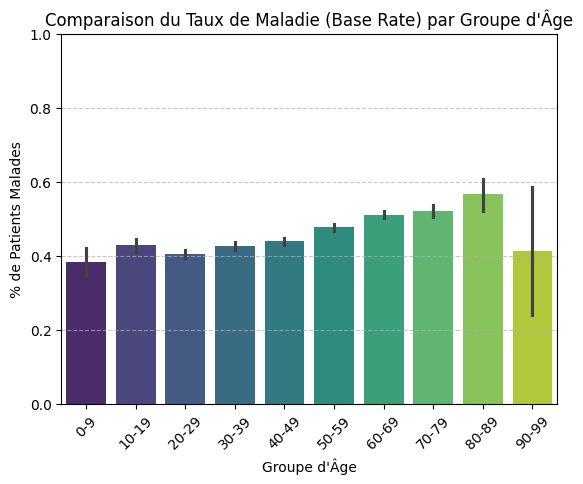

In [24]:
# 1. Bin 'Patient Age' into categories (10-year groups)
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']
df['Age_Group'] = pd.cut(df['Patient Age'], bins=bins, labels=labels, right=False, include_lowest=True)

sns.barplot(x='Age_Group', y='findings_bins', data=df, palette='viridis', hue='Age_Group', legend=False)
plt.title('Comparaison du Taux de Maladie (Base Rate) par Groupe d\'Âge')
plt.xlabel('Groupe d\'Âge')
plt.ylabel('% de Patients Malades')
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.ylim(0, 1) # Ensure y-axis is from 0 to 1 for percentage
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

On remarque que plus les individus sont agés, plus ils sont malades. La dernière catégorie (90-99 ans) est a prendre avec précaution
- on peut émettre l'hypithèse que les persinnes de cette classe d'age meurent davantage et sont donc paradoxalement moins malades
- on peut aussi émettre l'hypothèse que comme cette classe d'age est très peu présente dans le dataset, il y a une forte variabilité possible.


**C'est pour ça qu'on revient à une analyse avec des déciles et non des groupes d'age fixes** :


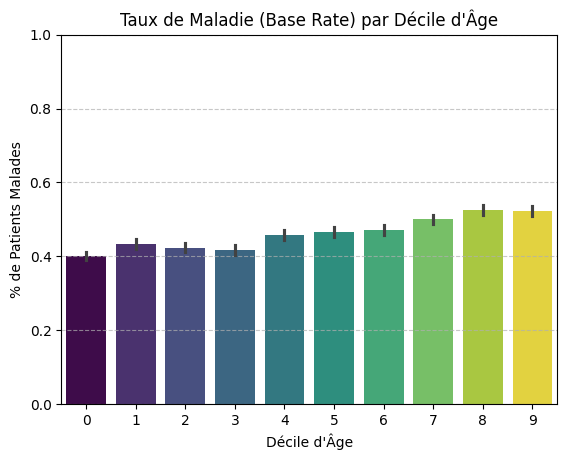

In [25]:
sns.barplot(x='Age_Decile', y='findings_bins', data=df, palette='viridis', hue='Age_Decile', legend=False)

plt.title('Taux de Maladie (Base Rate) par Décile d\'Âge')
plt.xlabel('Décile d\'Âge')
plt.ylabel('% de Patients Malades')

# Ajustements esthétiques
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

On confirme que la tendance est que plus les personnes sont agées, plus elles sont malades, et que les 90-99 ans sont trop peu nombreux pour conclure (cf graphique d'avant difficile à interpréter).

### Taux de maladie par view position

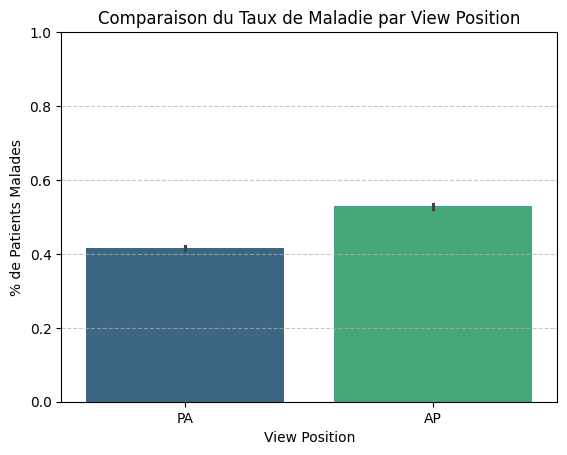

In [26]:
sns.barplot(x='View Position', y='findings_bins', data=df, hue='View Position', palette='viridis', legend=False)
plt.title('Comparaison du Taux de Maladie par View Position')
plt.xlabel('View Position')
plt.ylabel('% de Patients Malades')
plt.ylim(0, 1) # Ensure y-axis is from 0 to 1 for percentage
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

On remarque qu'il y a davantage de personnes malades qui ont été scannées dans la position AP que dans la position PA, alors même que davantage de persones avaient été scannées dans la position PA que dans la position AP. Conclusion : La position AP est un indicateur indirect (proxy) de la gravité de l'état du patient. Le taux de maladie plus élevé en AP n'est pas dû à la position elle-même, mais au fait que les patients scannés en AP sont déjà, par définition, plus susceptibles d'être malades.

### Relations entre Genre et View Position

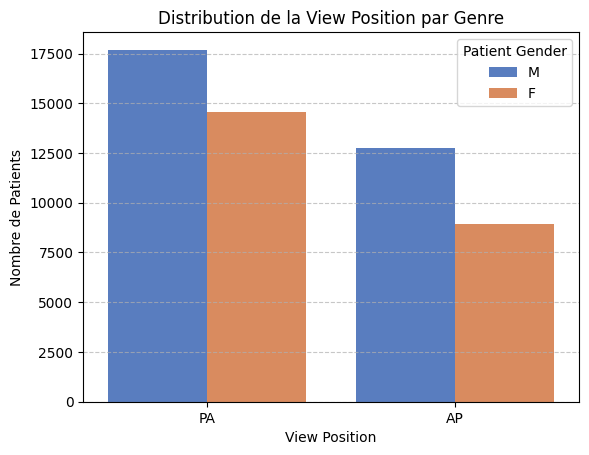

In [27]:

sns.countplot(x='View Position', hue='Patient Gender', data=df, palette='muted')
plt.title('Distribution de la View Position par Genre')
plt.xlabel('View Position')
plt.ylabel('Nombre de Patients')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Ce graphique montre le nombre de scans pour chaque type de 'View Position' (AP, PA), séparé par genre. Il permet de voir si un type de vue est plus fréquemment utilisé pour un genre par rapport à l'autre, ce qui pourrait révéler des biais dans les protocoles d'acquisition d'images.

En l'occurrence, on observe qu'il y a davanytage de scans PA que AP (comme vu précédemment, **donc absence de biais d'échantillonage (?)**), mais surtout que dans les deux positions, davanytage d'hommes que de femmes ont été scannées. Cela confirme simplement que le déséquilibre de genre (56,4 % d'hommes contre 43,6 % de femmes) n'est pas un accident local, mais qu'il est présent partout.

Si une inversion avait eu lieu (davantage de femmes en AP et d'hommes en PA), on peut se demander si ça aurait créé de biais. Peut être que le biais créé serait le suviant : genre => position => diagnostic ?

### 3 variables : Distribution des maladies par age et genre (la mettre a la toute fin de l'analyse bivariée)

Ensuite, on peut commencer cette analyse qui combine trois variables en binarisant l'age avec un treshold = 60 ans, age arbitraire pour définir une "personne agée".

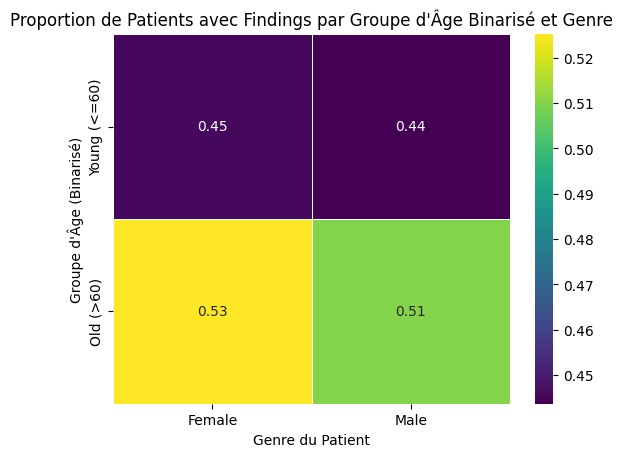

In [28]:
# Ensure 'is_old' column is present by re-creating it
df['is_old'] = df['Patient Age'].apply(lambda x: 1 if x > 60 else 0)

# Ensure 'sex' column is present by creating it from 'Patient Gender'
df['sex'] = df['Patient Gender'].map({'F': 0, 'M': 1})

# Calculate the mean of 'findings_bins' for each 'is_old' and 'sex' combination
# The mean of a binary variable (0 or 1) represents the proportion of 1s.
# Explicitly set 'observed=False' to silence the FutureWarning
heatmap_data_bin_age = df.pivot_table(values='findings_bins', index='is_old', columns='sex', aggfunc='mean', observed=False)

# Rename columns and index for better readability on the heatmap
heatmap_data_bin_age.rename(columns={0: 'Female', 1: 'Male'}, inplace=True);
heatmap_data_bin_age.rename(index={0: 'Young (<=60)', 1: 'Old (>60)'}, inplace=True);

sns.heatmap(heatmap_data_bin_age, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Proportion de Patients avec Findings par Groupe d\'Âge Binarisé et Genre')
plt.xlabel('Genre du Patient')
plt.ylabel('Groupe d\'Âge (Binarisé)')
plt.show()

On se rend compte que les personnes plus agées et les femmes (dans une moindre mesure) ont tendance a être davantage diagnostiquées comme ayant une maladie quelconque. Pour aller plus loin dans les analyses visuelles, on peut découper l'age en trahcnes d'age au lieu de simplement le binariser.


Dans la suite de cette petite partie de l'analyse, on teste deux manières différentes de découper l'age (avec ```.cut``` et ```.qcut```)



**Première manière de découper l'age**

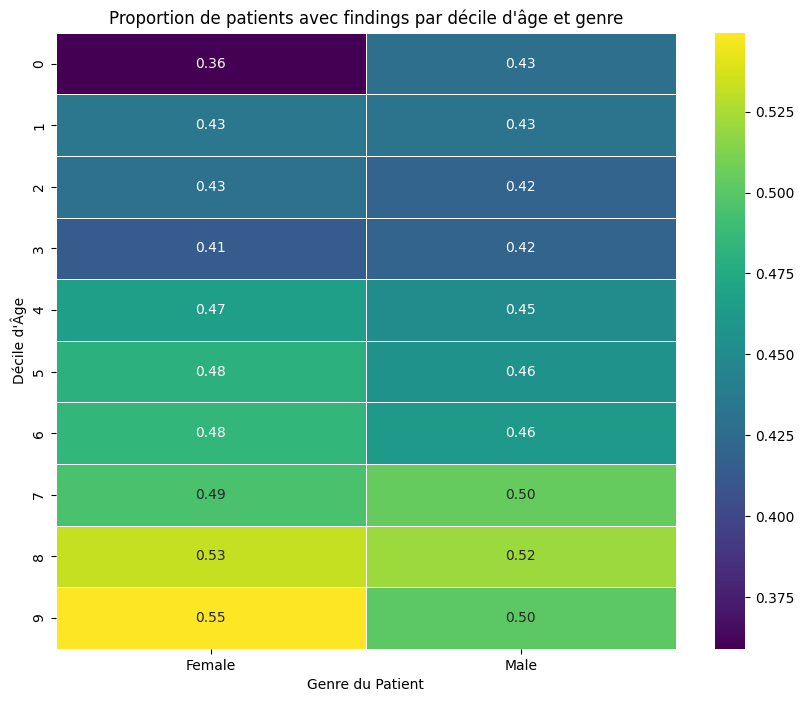

In [29]:

# Calculate the mean of 'findings_bins' for each Age_Decile and sex combination
# The mean of a binary variable (0 or 1) represents the proportion of 1s.
# Explicitly set 'observed=False' to silence the FutureWarning
heatmap_data = df.pivot_table(values='findings_bins', index='Age_Decile', columns='sex', aggfunc='mean', observed=False)

# Rename columns for better readability on the heatmap
heatmap_data.rename(columns={0: 'Female', 1: 'Male'}, inplace=True)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Proportion de patients avec findings par décile d\'âge et genre')
plt.xlabel('Genre du Patient')
plt.ylabel('Décile d\'Âge')
plt.show()


  Chaque cellule représente la proportion de patients qui ont un diagnostic (findings_bins = 1) pour un décile d'âge et un genre donné. Une valeur plus élevée indique qu'une plus grande proportion de patients dans ce groupe particulier sont diagnostiqués malades.
  On observe des variations de proportions à travers les déciles d'âge et entre les genres.
  
  - Pour les femmes : La proportion de diagnostics tend à augmenter avec l'âge jusqu'aux déciles plus élevés, puis elle peut stagner ou légèrement diminuer.
  
  - Pour les hommes : La proportion suit une tendance similaire d'augmentation avec l'âge, mais on note une baisse inattendue chez les hommes les plus âgés (décile 9), *peut etre parce que les hommes vivent moins logntemps que les femmes* ?

  - Si on compare les stats entre hommes et femmes, on remarque que les femmes sont très légèrement davantages diagnostiqu"es que les hommes, à l'exception du décile D0. En revanche, est-ce réellement statistiquement significatif ? les écarts ne semblent pas grands.



  **sur le paradoxe de simpson** : Je pense qu'il n'y en a pas. Pour qu'il y ait un paradoxe de Simpson, il faudrait que la tendance globale s'inverse dans les sous-groupes.

  Au global : Les femmes et les hommes ont quasiment le même taux de maladie (~0.46).

  Par décile d'âge : Les taux restent très proches entre hommes et femmes pour chaque ligne. Il n'y a pas d'inversion majeure (par exemple, les hommes ne sont pas systématiquement à 0.80 et les femmes à 0.20 dans les sous-groupes).





  **Deuxième manière de découper l'age : On refait la même visualisation en tranches d'ages de 10 ans** au lieu des déciles, pour se rendre compte de l'importance des déciles

Value counts for new 'Age_Group' column (10-year groups):
Age_Group
0-9        637
10-19     2801
20-29     5883
30-39     8493
40-49    10076
50-59    13033
60-69     9216
70-79     3234
80-89      520
90-99       29
Name: count, dtype: int64


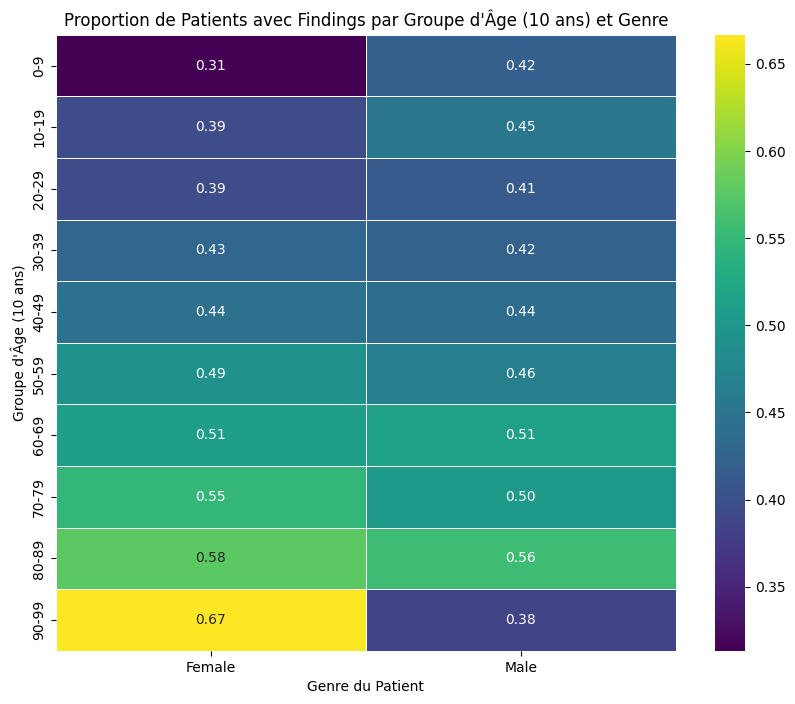

In [30]:
# 1. Bin 'Patient Age' into categories (10-year groups)
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']
df['Age_Group'] = pd.cut(df['Patient Age'], bins=bins, labels=labels, right=False, include_lowest=True)

print("Value counts for new 'Age_Group' column (10-year groups):")
print(df['Age_Group'].value_counts().sort_index())

# Encode 'Patient Gender' into 'sex' (0=F, 1=M)
df['sex'] = df['Patient Gender'].map({'F': 0, 'M': 1})

# Calculate the mean of 'findings_bins' for each Age_Group and sex combination
heatmap_data_10yr = df.pivot_table(values='findings_bins', index='Age_Group', columns='sex', aggfunc='mean', observed=False)

# Rename columns for better readability on the heatmap
heatmap_data_10yr.rename(columns={0: 'Female', 1: 'Male'}, inplace=True)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_10yr, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Proportion de Patients avec Findings par Groupe d\'Âge (10 ans) et Genre')
plt.xlabel('Genre du Patient')
plt.ylabel('Groupe d\'Âge (10 ans)')
plt.show()

- On observe globaleme,nt les mêmes tendances que plus haut, sauf que cette visualisation est plus complexe a analyser car elle dépend beaucoup de la représentativité des classes d'ages (par xexemple, très peu de très jeunes et de très agés dans ce dataset)

- Conséquence : Le cas des '90-99 ans' : Pour le groupe d'âge 90-99, la proportion pour les femmes est de 0.67 tandis que pour les hommes, elle est de 0.38. Cependant, étant donné le très faible nombre de patients dans ce groupe (29 au total), en particulier pour les hommes (seulement 13 hommes entre 90 et 99 ans dans le dataset, comme on peut le déduire des chiffres des déciles et genres), cette différence pourrait être due au hasard ou à la taille réduite de l'échantillon plutôt qu'à un réel biais démographique ou biologique. Il est important de ne pas tirer de conclusions hâtives de ces chiffres extrêmes. **C'est pour cette raison qu'on utulise des déciles et non pas des tranches d'âge dans ce genre d'analyse.**

### 3 variables : Distribution des maladies par age et view position

On réeffectue la même visualisation mais en replaçant le genre par la view position

Value counts for new 'Age_Decile' column:
Age_Decile
0    5513
1    5389
2    5989
3    5402
4    5597
5    4959
6    5268
7    5982
8    4827
9    4996
Name: count, dtype: int64


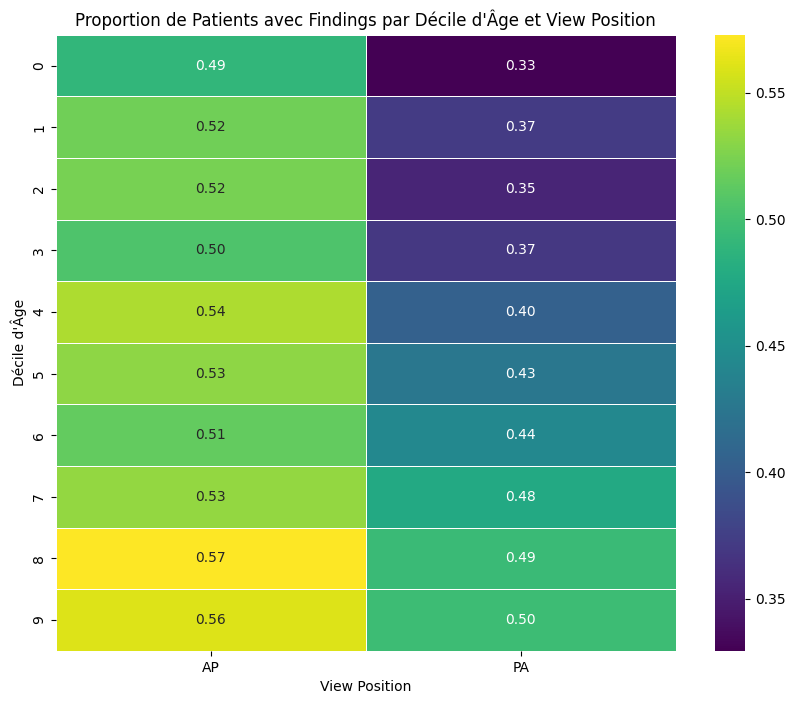

In [31]:
# 1. Ensure 'Age_Decile' is present (re-creating if necessary, though it should be)
df['Age_Decile'] = pd.qcut(df['Patient Age'], q=10, labels=False, duplicates='drop')

print("Value counts for new 'Age_Decile' column:")
print(df['Age_Decile'].value_counts().sort_index())

# Calculate the mean of 'findings_bins' for each Age_Decile and View Position combination
heatmap_data_viewpos = df.pivot_table(values='findings_bins', index='Age_Decile', columns='View Position', aggfunc='mean', observed=False)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_viewpos, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Proportion de Patients avec Findings par Décile d\'Âge et View Position')
plt.xlabel('View Position')
plt.ylabel('Décile d\'Âge')
plt.show()




* Tendance générale : Comme précédemment, la proportion de diagnostics tend à augmenter avec l'âge pour les deux types de 'View Position'.
* Comparaison AP vs PA : On observe de manière assez constante que la proportion de diagnostics est plus élevée pour la position AP que pour la position PA dans la plupart des déciles d'âge. Cela suggère qu'une vue AP est plus fréquemment associée à un diagnostic positif, ou est privilégiée pour les patients ayant une condition médicale identifiée ou suspectée.
* Points à noter : Il est intéressant de voir les variations entre les déciles. Par exemple, le décile 0 (les plus jeunes) montre une proportion plus élevée en AP (0.49) qu'en PA (0.33), ce qui pourrait refléter des protocoles d'imagerie différents pour les jeunes patients ou pour des conditions spécifiques.

Cette analyse réitère que la 'View Position' n'est pas un facteur anodin et qu'elle est corrélée de manière significative à la présence de diagnostics, ce qui pourrait indiquer des biais de sélection ou des pratiques cliniques spécifiques à ces types de vues.

## Conclusion stats desc

Les analyses univariées nous ont permis de visualiser la distribution de chaque variable dans le dataset. Nous avons observé une surreprésentation masculine et une prédominance de la position de vue PA sur la position AP.

Pour affirmer l'existence d'un biais de sélection, il est nécessaire de comparer ces distributions avec la population réelle, bien que cette comparaison soit complexe dans le cadre de ce projet


Pour identifier de potentiels biais plus profonds, nous avons réalisé des analyses multivariées qui ont révélé des interactions critiques :

- Nous avons visualisé que la position AP est fortement corrélée à un taux de maladie plus élevé par rapport à la position PA. Cette variable "View Position" agit comme un proxy de l'état clinique du patient, car les patients les plus sévèrement atteints sont souvent scannés au lit (position AP).

- Pour étudier l'age, il a été important de segmenter l'age par déciles : Le passage de tranches d'âge fixes à des déciles d'âge a été déterminant pour stabiliser nos analyses. Cela nous a permis d'éliminer les petits effectifs ayant une forte variabilité (notamment chez les plus âgés) et de confirmer une augmentation quasi linéaire du risque avec l'âge pour les deux genres.

- Le croisement genre/position montre que les femmes sont encore moins représentées dans la catégorie à haut risque (AP).

- les visualisations avec trois varaibles nous ont permis d'aller plus loin que les analyses bivariées.

# Mesure des biais





## Définition des mesures


Pour quantifier les biais dans notre dataset, nous allons utiliser deux métriques clés :

*   **Statistical Parity Difference (SPD)** :
    *   **Définition** : Le SPD mesure la différence entre le taux de résultats favorables pour le groupe non privilégié et le taux de résultats favorables pour le groupe privilégié. Dans notre cas, un résultat favorable est `findings_bins = 1` (malade, car c'est la condition que l'on cherche à détecter).
    *   **Formule** : $SPD = P(Y=1|A=Unprivileged) - P(Y=1|A=Privileged)$
    *   **Interprétation** : Un SPD proche de 0 indique l'absence de biais de parité statistique. Un SPD positif signifie que le groupe non privilégié a un taux plus élevé de résultats `1` (malade), tandis qu'un SPD négatif signifie l'inverse. **For the statistical parity difference, a value in the range (-0.15, 0.2] correspond to a pass** (cf https://www.mathworks.com/help/risk/fairness-metrics-in-modelscape.html) => mais cette range est un peu trop élevée dans notre contexte.

*   **Disparate Impact (DI)** :
    *   **Définition** : Le DI mesure le ratio du taux de résultats favorables entre le groupe non privilégié et le groupe privilégié.
    *   **Formule** : $DI = \frac{P(Y=1|A=Unprivileged)}{P(Y=1|A=Privileged)}$
    *   **Interprétation** : Un DI proche de 1 indique l'absence de biais d'impact disparate. Un DI inférieur à 0.8 ou supérieur à 1.25 est souvent considéré comme indiquant un biais significatif (règle des 80%).

In [32]:
# Code to compute fairness metrics using aif360

from aif360.sklearn.metrics import *
from sklearn.metrics import  balanced_accuracy_score


# This method takes lists
def get_metrics(
    y_true, # list or np.array of truth values
    y_pred=None,  # list or np.array of predictions
    prot_attr=None, # list or np.array of protected/sensitive attribute values
    priv_group=1, # value taken by the privileged group
    pos_label=1, # value taken by the positive truth/prediction
    sample_weight=None # list or np.array of weights value,
):
    group_metrics = {}
    group_metrics["base_rate_truth"] = base_rate(
        y_true=y_true, pos_label=pos_label, sample_weight=sample_weight
    )
    group_metrics["statistical_parity_difference"] = statistical_parity_difference(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
    )
    group_metrics["disparate_impact_ratio"] = disparate_impact_ratio(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
    )
    if not y_pred is None:
        group_metrics["base_rate_preds"] = base_rate(
        y_true=y_pred, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["equal_opportunity_difference"] = equal_opportunity_difference(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["average_odds_difference"] = average_odds_difference(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
        )
        if len(set(y_pred))>1:
            group_metrics["conditional_demographic_disparity"] = conditional_demographic_disparity(
                y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
            )
        else:
            group_metrics["conditional_demographic_disparity"] =None
        group_metrics["smoothed_edf"] = smoothed_edf(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["df_bias_amplification"] = df_bias_amplification(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["balanced_accuracy_score"] = balanced_accuracy_score(
        y_true=y_true, y_pred=y_pred, sample_weight=sample_weight
        )
    return group_metrics

/usr/local/lib/python3.12/dist-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/usr/local/lib/python3.12/dist-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_discounted

## Biais du genre

In [33]:
print(" Calculs pour le Genre avec get_metrics")

# Call get_metrics for Gender
gen_metrics_gender = get_metrics(
    y_true=df['findings_bins'],
    prot_attr=df['sex'],
    priv_group=1, # 1 for Male (privileged group)
    pos_label=1 # 1 for 'is_sick' / 'findings_bins'
)

print(f"Statistical Parity Difference (SPD) pour le Genre: {gen_metrics_gender['statistical_parity_difference']:.3f}")
print(f"Disparate Impact (DI) pour le Genre: {gen_metrics_gender['disparate_impact_ratio']:.3f}")

if abs(gen_metrics_gender['statistical_parity_difference']) < 0.05:
    print("Interprétation SPD: Le SPD est proche de 0, suggérant une faible disparité statistique par rapport au genre.")
else:
    print("Interprétation SPD: Le SPD est significatif, indiquant une disparité statistique par rapport au genre.")

if 0.8 <= gen_metrics_gender['disparate_impact_ratio'] <= 1.25:
    print("Interprétation DI: Le DI est entre 0.8 et 1.25, suggérant une faible disparité d'impact par rapport au genre (pas de biais significatif selon la règle des 80%).")
else:
    print("Interprétation DI: Le DI est en dehors de la plage [0.8, 1.25], indiquant une disparité d'impact significative par rapport au genre.")


 Calculs pour le Genre avec get_metrics
Statistical Parity Difference (SPD) pour le Genre: 0.003
Disparate Impact (DI) pour le Genre: 1.006
Interprétation SPD: Le SPD est proche de 0, suggérant une faible disparité statistique par rapport au genre.
Interprétation DI: Le DI est entre 0.8 et 1.25, suggérant une faible disparité d'impact par rapport au genre (pas de biais significatif selon la règle des 80%).


## Biais de l'age

https://gemini.google.com/share/fa3af09e9cf1

In [34]:
print("Calculs pour l'age avec get_metrics")

# Call get_metrics for Age
gen_metrics_age = get_metrics(
    y_true=df['findings_bins'],
    prot_attr=df['is_old'],
    priv_group=0, # 0 for Young (privileged group)
    pos_label=1 # 1 for 'is_sick' / 'findings_bins'
)

print(f"Statistical Parity Difference (SPD) pour l'Âge: {gen_metrics_age['statistical_parity_difference']:.3f}")
print(f"Disparate Impact (DI) pour l'Âge: {gen_metrics_age['disparate_impact_ratio']:.3f}")

if abs(gen_metrics_age['statistical_parity_difference']) < 0.05:
    print("Interprétation SPD: Le SPD est proche de 0, suggérant une faible disparité statistique par rapport à l'âge.")
else:
    print("Interprétation SPD: Le SPD est significatif, indiquant une disparité statistique par rapport à l'âge.")

if 0.8 <= gen_metrics_age['disparate_impact_ratio'] <= 1.25:
    print("Interprétation DI: Le DI est entre 0.8 et 1.25, suggérant une faible disparité d'impact par rapport à l'âge (pas de biais significatif selon la règle des 80%).")
else:
    print("Interprétation DI: Le DI est en dehors de la plage [0.8, 1.25], indiquant une disparité d'impact significative par rapport à l'âge.")

Calculs pour l'age avec get_metrics
Statistical Parity Difference (SPD) pour l'Âge: 0.072
Disparate Impact (DI) pour l'Âge: 1.162
Interprétation SPD: Le SPD est significatif, indiquant une disparité statistique par rapport à l'âge.
Interprétation DI: Le DI est entre 0.8 et 1.25, suggérant une faible disparité d'impact par rapport à l'âge (pas de biais significatif selon la règle des 80%).


On en conclut qu'il y a un biais en observant le SPD, mais pas le DI. Mais ici, on  asimplement binarisé l'age, alors qu'on pourrait aller plus loin en considérant des déciles d'age.


Pour éviter de faire énormément de calculs de DI et de SPD (une centaine calculs de métriques en tout je crois), on définit le groupe de référence (privilégié) comme la tranche d'age qui a le plus de diagnostiques positifs. C'est contrintuitif, car on piurrait penser qu'être privilégié, c'est être en bonne santé (valeur No findings dans la variable de diagnostic).  **Mais ici on considère qu'on veut limiter le nombre de faux négatifs** (cela dépend du contexte métier...).

In [35]:
import pandas as pd
import numpy as np

# --- 1. Configuration des variables ---
TARGET_COL = 'findings_bins'  # Votre variable cible
AGE_COL = 'Age_Decile'          # La colonne contenant vos tranches d'âge (ex: '18-30', '30-45', etc.)
POS_LABEL = 1                 # La valeur positive à prédire/détecter

print("Analyse détaillée des biais par tranche d'âge")

# --- 2. Trouver automatiquement la tranche de référence (Groupe Privilégié) ---
# On calcule le taux de cas positifs pour chaque tranche d'âge
taux_positifs = df.groupby(AGE_COL)[TARGET_COL].mean()

# On sélectionne la tranche avec le taux le plus élevé
ref_group = taux_positifs.idxmax()
meilleur_taux = taux_positifs.max()

print(f"\n[Info] Taux de positifs par tranche d'âge :\n{taux_positifs}")
print(f"-> Tranche de référence sélectionnée : '{ref_group}' (Taux max: {meilleur_taux:.3f})\n")

# --- 3. Calcul des métriques pour chaque tranche vs Référence ---
results_list = []
unique_groups = df[AGE_COL].unique()

for group in unique_groups:
    if pd.isna(group): # Ignorer les éventuelles valeurs nulles
        continue

    if group == ref_group:
        # Pour le groupe de référence, les métriques comparées à lui-même sont parfaites par définition
        results_list.append({
            'Tranche d\'âge': group,
            'Rôle': 'Référence',
            'SPD (vs Réf)': 0.000,
            'DI (vs Réf)': 1.000,
            'Biais Détecté': 'N/A'
        })
        continue

    # Créer un masque pour isoler UNIQUEMENT la Référence et le Groupe actuel
    mask = df[AGE_COL].isin([ref_group, group])
    df_subset = df[mask]

    # Appeler votre fonction get_metrics sur ce sous-ensemble
    # Note: On passe y_pred=None si vous analysez le biais des données (vérité terrain)
    metrics = get_metrics(
        y_true=df_subset[TARGET_COL],
        y_pred=None, # Mettez df_subset['vos_predictions'] ici si vous évaluez un modèle
        prot_attr=df_subset[AGE_COL],
        priv_group=ref_group,
        pos_label=POS_LABEL
    )

    spd = metrics['statistical_parity_difference']
    di = metrics['disparate_impact_ratio']

    # Interprétation stricte : SPD proche de 0, DI entre 0.8 et 1.25
    bias_status = "Non"
    if abs(spd) > 0.05 or not (0.8 <= di <= 1.25):
        bias_status = "Oui (Significatif)"

    results_list.append({
        'Tranche d\'âge': group,
        'Rôle': 'Comparé',
        'SPD (vs Réf)': spd,
        'DI (vs Réf)': di,
        'Biais Détecté': bias_status
    })

# --- 4. Affichage formel des résultats ---
results_df = pd.DataFrame(results_list)

# Tri optionnel pour mettre la référence en haut, puis trier alphabétiquement/numériquement
results_df = results_df.sort_values(by=['Rôle', 'Tranche d\'âge'], ascending=[False, True])

print("Résultats des métriques d'équité (Fairness) par paire :")
print(results_df.to_markdown(index=False, floatfmt=".3f"))

Analyse détaillée des biais par tranche d'âge

[Info] Taux de positifs par tranche d'âge :
Age_Decile
0    0.400871
1    0.432919
2    0.423944
3    0.416698
4    0.457567
5    0.466223
6    0.471526
7    0.500334
8    0.525378
9    0.521817
Name: findings_bins, dtype: float64
-> Tranche de référence sélectionnée : '8' (Taux max: 0.525)

Résultats des métriques d'équité (Fairness) par paire :
|   Tranche d'âge | Rôle      |   SPD (vs Réf) |   DI (vs Réf) | Biais Détecté      |
|----------------:|:----------|---------------:|--------------:|:-------------------|
|               8 | Référence |          0.000 |         1.000 | N/A                |
|               0 | Comparé   |         -0.125 |         0.763 | Oui (Significatif) |
|               1 | Comparé   |         -0.092 |         0.824 | Oui (Significatif) |
|               2 | Comparé   |         -0.101 |         0.807 | Oui (Significatif) |
|               3 | Comparé   |         -0.109 |         0.793 | Oui (Significatif) |
| 

**conclusion** : Lecture possible pour le décile 0 :
- SPD de -0,125 [**Taux du Décile 0 (0,400) - Taux du Décile 8 (0,525) = -0,125**] : Il y a un écart absolu de 12,5 % de diagnostics positifs en moins par rapport aux seniors.     Un SPD négatif signifie que le groupe privilégié a un taux plus élevé de résultats 1 (malade) que le groupe 0 (non privilégié ici)



- DI de 0,763 [**0,400/0,525=0,762**] : Ce score est inférieur au seuil critique de 0,8. Cela signifie qu'un patient du Décile 0 a environ 24 % de chances en moins de recevoir un diagnostic positif qu'un patient du Décile 8.

- C'est ici que le risque de faux négatifs est le plus élevé, mais il reste à déterminer si cette différence est d'origine médicale (prévalence réelle de la maladie différente entre les déciles d'age) ou si elle révèle un défaut de détection pour le les déciles non privilégiés, qui pourrait faire que le taux de faux négatifs des groupes non privilégiés est anormalement élevé.

## Biais pour la View position

Comme pour l'age, on choisir le groupe privilégiécomme étant le plus diagnostiqué, dans un but d'éviter les faux négatifs.

In [36]:
# Encode 'View Position' into numerical values
df['view_pos_encoded'] = df['View Position'].map({'PA': 0, 'AP': 1})

In [37]:
# Encode 'View Position' into numerical values
df['view_pos_encoded'] = df['View Position'].map({'PA': 0, 'AP': 1})

print("Calculs pour la View Position avec get_metrics")

# Call get_metrics for View Position
gen_metrics_view_pos = get_metrics(
    y_true=df['findings_bins'],
    prot_attr=df['view_pos_encoded'],
    priv_group=1, # 1 for AP (privileged group, highest sickness rate)
    pos_label=1 # 1 for 'is_sick' / 'findings_bins'
)

print(f"Statistical Parity Difference (SPD) pour la View Position: {gen_metrics_view_pos['statistical_parity_difference']:.3f}")
print(f"Disparate Impact (DI) pour la View Position: {gen_metrics_view_pos['disparate_impact_ratio']:.3f}")

if abs(gen_metrics_view_pos['statistical_parity_difference']) < 0.05:
    print("Interprétation SPD: Le SPD est proche de 0, suggérant une faible disparité statistique par rapport à la View Position.")
else:
    print("Interprétation SPD: Le SPD est significatif, indiquant une disparité statistique par rapport à la View Position.")

if 0.8 <= gen_metrics_view_pos['disparate_impact_ratio'] <= 1.25:
    print("Interprétation DI: Le DI est entre 0.8 et 1.25, suggérant une faible disparité d'impact par rapport à la View Position (pas de biais significatif selon la règle des 80%).")
else:
    print("Interprétation DI: Le DI est en dehors de la plage [0.8, 1.25], indiquant une disparité d'impact significative par rapport à la View Position.")

Calculs pour la View Position avec get_metrics
Statistical Parity Difference (SPD) pour la View Position: -0.113
Disparate Impact (DI) pour la View Position: 0.785
Interprétation SPD: Le SPD est significatif, indiquant une disparité statistique par rapport à la View Position.
Interprétation DI: Le DI est en dehors de la plage [0.8, 1.25], indiquant une disparité d'impact significative par rapport à la View Position.


Il y a bien un biais pour la View Position :

Le SPD négatif signifie que le groupe non-privilégié PA a un taux de diagnostic plus faible que le groupe privilégié AP.

Le Disparate Impact (0.785) est en dehors de la plage [0.8, 1.25], ce qui indique une disparité significative (biais). Le groupe non privilégié (PA) a environ 0.79 fois autant de chances (ou 21.5% de chances en moins) d'être diagnostiqué que le groupe privilégié (AP). Le Disparate Impact de 0.79 indique donc une disparité statistique. Il reste à déterminer si cette différence est d'origine médicale (prévalence réelle de la maladie différente entre PA et AP) ou si elle révèle un défaut de détection pour le groupe PA, qui pourrait faire que le taux de faux négatifs du groupe PA est anormalement élevé.

# Mitigation

ici, on va tester plusieurs méthodes de mitigation pré-processing et les comparer

- massaging

- reweighing

- uniform sampling

- preferential sampling

- disparate impact remover

- représentation latente fair

## Reweighing

In [38]:
from aif360.datasets import StandardDataset
from aif360.algorithms.preprocessing import Reweighing

# Define the protected attribute and target variable
protected_attribute_name = 'view_pos_encoded'
label_name = 'findings_bins'

# Define privileged and unprivileged groups for View Position
# We consider 'PA' (0) as privileged and 'AP' (1) as unprivileged based on prior bias analysis
unprivileged_groups = [{protected_attribute_name: 1}]
privileged_groups = [{protected_attribute_name: 0}]

# Convert pandas DataFrame to AIF360 StandardDataset
# We include all columns as features, and specify the label and protected attribute
dataset_orig = StandardDataset(df,
                               label_name=label_name,
                               protected_attribute_names=[protected_attribute_name],
                               favorable_classes=[1], # '1' is the favorable class for 'findings_bins' (presence of finding)
                               privileged_classes=[[0]], # '0' (PA) is the privileged class for 'view_pos_encoded'
                               features_to_drop=['Image Index', 'Finding Labels', 'Patient Gender', 'View Position', 'Age_Group'] # Exclude non-numerical columns, including 'Age_Group'
                              )

# Initialize the Reweighing algorithm
RW = Reweighing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Fit the Reweighing model on the original dataset
# This calculates the instance weights needed for debiasing
RW.fit(dataset_orig)

# Transform the original dataset with the learned weights
# The transformed dataset will have adjusted instance_weights
dataset_transf = RW.transform(dataset_orig)

# Extract the instance weights and add them back to the original DataFrame
df['instance_weights'] = dataset_transf.instance_weights

print("Reweighing applied successfully for 'View Position'.")
print("A new column 'instance_weights' has been added to the DataFrame.")
print(df[['View Position', 'view_pos_encoded', 'findings_bins', 'instance_weights']].head())

Reweighing applied successfully for 'View Position'.
A new column 'instance_weights' has been added to the DataFrame.
  View Position  view_pos_encoded  findings_bins  instance_weights
0            PA                 0              1          1.109664
1            PA                 0              1          1.109664
2            PA                 0              1          1.109664
3            PA                 0              1          1.109664
4            PA                 0              1          1.109664


In [39]:
print("### Vérification des biais pour la View Position après Reweighing")

# Call get_metrics for View Position, now including sample_weights
gen_metrics_view_pos_reweighted = get_metrics(
    y_true=df['findings_bins'],
    prot_attr=df['view_pos_encoded'],
    priv_group=0, # 0 for PA (privileged group)
    pos_label=1, # 1 for 'is_sick' / 'findings_bins'
    sample_weight=df['instance_weights'] # Use the instance weights
)

print(f"Statistical Parity Difference (SPD) pour la View Position (pondéré): {gen_metrics_view_pos_reweighted['statistical_parity_difference']:.3f}")
print(f"Disparate Impact (DI) pour la View Position (pondéré): {gen_metrics_view_pos_reweighted['disparate_impact_ratio']:.3f}")

print("\n--- Comparaison Avant vs Après Reweighing ---")
print(f"SPD AVANT Reweighing : {gen_metrics_view_pos['statistical_parity_difference']:.3f}")
print(f"SPD APRÈS Reweighing  : {gen_metrics_view_pos_reweighted['statistical_parity_difference']:.3f}")
print(f"DI AVANT Reweighing : {gen_metrics_view_pos['disparate_impact_ratio']:.3f}")
print(f"DI APRÈS Reweighing  : {gen_metrics_view_pos_reweighted['disparate_impact_ratio']:.3f}")

if abs(gen_metrics_view_pos_reweighted['statistical_parity_difference']) < 0.05:
    print("\nInterprétation SPD (après pondération): Le SPD est proche de 0, suggérant que le biais de parité statistique par rapport à la View Position a été efficacement réduit.")
else:
    print("\nInterprétation SPD (après pondération): Le SPD reste significatif, ce qui indique que le Reweighing n'a pas entièrement éliminé le biais de parité statistique pour la View Position.")

if 0.8 <= gen_metrics_view_pos_reweighted['disparate_impact_ratio'] <= 1.25:
    print("Interprétation DI (après pondération): Le DI est maintenant entre 0.8 et 1.25, suggérant que le biais d'impact disparate par rapport à la View Position a été efficacement réduit.")
else:
    print("Interprétation DI (après pondération): Le DI est toujours en dehors de la plage [0.8, 1.25], ce qui indique que le Reweighing n'a pas entièrement éliminé le biais d'impact disparate pour la View Position.")

### Vérification des biais pour la View Position après Reweighing
Statistical Parity Difference (SPD) pour la View Position (pondéré): -0.000
Disparate Impact (DI) pour la View Position (pondéré): 1.000

--- Comparaison Avant vs Après Reweighing ---
SPD AVANT Reweighing : -0.113
SPD APRÈS Reweighing  : -0.000
DI AVANT Reweighing : 0.785
DI APRÈS Reweighing  : 1.000

Interprétation SPD (après pondération): Le SPD est proche de 0, suggérant que le biais de parité statistique par rapport à la View Position a été efficacement réduit.
Interprétation DI (après pondération): Le DI est maintenant entre 0.8 et 1.25, suggérant que le biais d'impact disparate par rapport à la View Position a été efficacement réduit.


## LFR

In [40]:
from aif360.algorithms.preprocessing import LFR

# Initialisation (demande un réglage de paramètres AZ, AY, AX pour l'équilibre)
LFR_algo = LFR(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups,
               k=10, Ax=0.1, Ay=1.0, Az=2.0)

dataset_transf = LFR_algo.fit_transform(dataset_orig)

KeyboardInterrupt: 

In [ ]:
# 1. Extraire les nouveaux labels et l'attribut protégé du dataset transformé
y_lfr = dataset_transf.labels.flatten()
prot_attr_lfr = dataset_transf.protected_attributes.flatten()

# 2. Calculer les métriques avec votre fonction get_metrics
gen_metrics_lfr = get_metrics(
    y_true=y_lfr,
    prot_attr=prot_attr_lfr,
    priv_group=0, # 0 pour PA
    pos_label=1   # 1 pour présence de finding
)

# 3. Affichage des résultats
spd_lfr = gen_metrics_lfr['statistical_parity_difference']
di_lfr = gen_metrics_lfr['disparate_impact_ratio']

print("### Vérification des biais après Learning Fair Representations (LFR)")
print(f"SPD pour la View Position (Post-LFR): {spd_lfr:.3f}")
print(f"DI pour la View Position (Post-LFR): {di_lfr:.3f}")

print("\n--- Comparaison Avant vs Après LFR ---")
# On suppose que gen_metrics_view_pos contient vos métriques initiales
print(f"SPD AVANT : {gen_metrics_view_pos['statistical_parity_difference']:.3f} -> SPD APRÈS LFR : {spd_lfr:.3f}")
print(f"DI AVANT  : {gen_metrics_view_pos['disparate_impact_ratio']:.3f} -> DI APRÈS LFR  : {di_lfr:.3f}")

# 4. Interprétation
if abs(spd_lfr) < 0.05:
    print("\nInterprétation : Le LFR a réussi à supprimer quasiment tout le biais de parité statistique.")
else:
    print("\nInterprétation : Il reste un léger biais, vous pourriez augmenter le paramètre 'Az' pour forcer plus d'équité.")

# Conclusion

Au travers de ce projet, nous avons pu étudier les biais inhérents a und ataset de deux manières différentes :
- grâce a de la datavisualisation, mais les mimites étaient qu'on pouvait difficilement quantifier ces biais
- grâe à des fairness metrics (SPD et DI), qui règlent le problème de la dataviz.

Nous avons pu partiellement confirmer certaines des hyopothèses faites sur les dataviz car nous avons trouvé quelques biais au niveau de la View Position et de l'age.

En revanche, le contexte émtier est très important dans l'interprétation des biais : est ce qu'un  Disparate Impact significatif indique un réel biais et donc potentiellement tro pde faux négatifs pour le groupe non privilégié, ou est ce que le dataset représente la réalité, et a prévalence des maladies pour le groue privilégié est ingérieure a la prévalence des maladies pour le groupe non privilégié ?

Par la suite, nous avons pu corriger ces biais, afin que par le futur, si nous entrainons un modèle sur ces données, il ne soit pas discriminant envers les groupes non privilégiés.

Parmis les deux méthodes testées, la plus facile et rapide a mettre en place est le reweighing. Elle est aussi plus facielement interprétable.